# Script for simulations and figures

**"A mathematical model of the effect of low-dose radiation effect on the G2 checkpoint"**

*Carlos Contreras, Gustavo Carrero and Gerda de Vries*

&copy; Carlos Contreras

In [1]:
using OrdinaryDiffEq, ParameterizedFunctions, NamedTuples
using PyDSTool, PyCall, PyPlot
using JLD

In [2]:
saveplots = true;

In [3]:
include("custom_functions.jl");
include("plot_functions.jl");

## 1 Module for the cell cycle with constant mass

The model includes interphase and M-phase

\begin{align}
\frac{d MPF}{dt}       &= k_{m0}Mass - (k_{m2} + k_{m2a}Wee1)\cdot MPF + (k_{m1} + k_{m1a}Cdc25)\cdot MPF_{P} - (k_{m3} + k_{m3a} APC)MPF, \\ 
\frac{d MPF_{P}}{dt}   & = (k_{m2} + k_{m2b}Wee1)MPF - (k_{m1} + k_{m1a}Cdc25)MPF_{P} - (k_{m3}+ k_{m3a} APC)MPF_{P},  \\
\frac{d Wee1}{dt}      &= V_{w1} \frac{Wee1_{T} - Wee1 }{J_{w1} + (Wee1_{T} - Wee1) }  - k_{w2} (MPF + \alpha MPF_{P}) \frac{Wee1}{J_{w2} + Wee1}, \\
\frac{d Cdc25}{dt} &= k_{c1} (MPF + \alpha MPF_{P}) \frac{Cdc25_{T} - Cdc25}{J_{c1} + (Cdc25_{T} - Cdc25)}  - V_{c2}\frac{Cdc25}{J_{c2} + Cdc25}, \\
\frac{d IE}{dt}    &= k_{i1} (MPF + \alpha MPF_{P})\frac{IE_{T} - IE}{J_{i1} + (IE_{T} - IE)} - V_{i2} \frac{IE}{J_{i2} + IE}, \\       
\frac{d APC}{dt}   &= k_{a1}IE_{A} \frac{APC_{T} - APC}{J_{a1}+(APC_{T} - APC)} - V_{a2}\frac{APC}{J_{a2}+APC} .
\end{align}

In [4]:
f1 = @ode_def_bare CCMMV001 begin
    ## System of ODE (vector field)
    dMPF   = k_m0*mass - (k_m2 + k_m2a*Wee1)*MPF + (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF
    dMPF_P = (k_m2 + k_m2a*Wee1)*MPF - (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF_P
    dWee1  = V_w1*(Wee1_T - Wee1)/(J_w1 + Wee1_T - Wee1) - k_w2*(MPF + MPF_P*alpha)*Wee1/(J_w2 + Wee1)
    dCdc25 = k_c1*(MPF + MPF_P*alpha)*(Cdc25_T - Cdc25)/(J_c1 + Cdc25_T - Cdc25) - V_c2*Cdc25/(J_c2 + Cdc25)
    dIE    = k_i1*(MPF + MPF_P*alpha)*(IE_T - IE)/(J_i1 + IE_T - IE) - V_i2*IE/(J_i2 + IE)
    dAPC   = k_a1*IE*(APC_T - APC)/(J_a1 + APC_T - APC) - V_a2*APC/(J_a2 + APC)
end k_m0 k_m1 k_m1a k_m2 k_m2a k_m3 k_m3a V_w1 k_w2 J_w1 J_w2 k_c1 V_c2 k_c2a J_c1 J_c2 k_i1 V_i2 J_i1 J_i2 k_a1 V_a2 J_a1 J_a2 alpha Wee1_T Cdc25_T IE_T APC_T Chk2_T theta_M mass;

### 1.1 Bifurcation diagram for mass when $V_{c2}=1.4$

Find the steady state during **interphase**

In [5]:
f1_p1 = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2, mass=0.5);

In [6]:
u0 = [0.006,      # MPF
      0.493,      # MPF_P
      0.998,      # Wee1
      0.002,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 40.0)
dtmax = 0.1
alg = Rosenbrock23()
prob = ODEProblem(f1, u0, tspan, f1_p1)
sol = solve(prob, alg; (:dtmax, dtmax))
f1_sol1 = sol
sol.errors

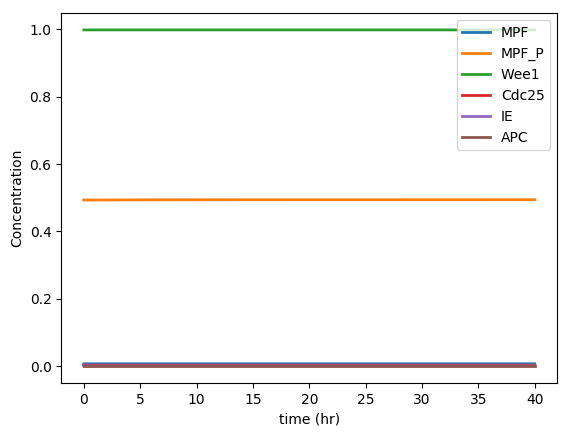

In [7]:
plot(sol.t, sol.u, lw=2)
xlabel("time (hr)")
ylabel("Concentration")
legend(labels = ["MPF","MPF_P","Wee1","Cdc25","IE","APC"])
show()

Find the limit cycle during the **M-phase**

In [8]:
f1_p2 = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2, mass=3.0);

In [9]:
u0 = [0.006,      # MPF
      0.493,      # MPF_P
      0.998,      # Wee1
      0.002,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 15.0)
dtmax = 0.001
sol = find_limit_cycle(f1, u0, tspan, f1_p2; (:dtmax, dtmax))
f1_cycle1 = sol
sol.errors

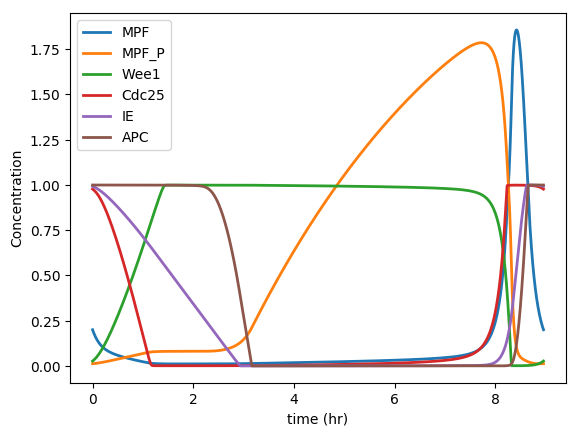

In [10]:
plot(sol.t, sol.u, lw=2)
xlabel("time (hr)")
ylabel("Concentration")
legend(labels = ["MPF","MPF_P","Wee1","Cdc25","IE","APC"])
show()

Follow the steady state from the stable node at the **interphase**

In [11]:
tspan = [0, 40]
dsargs = build_ode(f1, f1_sol1[end], tspan, f1_p1)
dsargs[:pdomain] = Dict("mass"=>[0.01, 4], "V_c2"=>[0.0, 6])
ode = ds[:Generator][:Vode_ODEsystem](dsargs)
ode[:set](pars = Dict("mass"=>0.5))
PC = ds[:ContClass](ode);

In [12]:
name1 = "EQ1"
PCargs = ds[:args](name=name1)
PCargs[:type] = "EP-C"
PCargs[:freepars] = ["mass"]
PCargs[:MaxNumPoints] = 300
PCargs[:MaxStepSize] = 5e-2
PCargs[:MinStepSize] = 1e-5
PCargs[:MaxTestIters] = 20
PCargs[:LocBifPoints] = "all"
PCargs[:SaveEigen] = true
PCargs[:StopAtPoints] = ["B"]
PCargs[:verbosity] = 2
PC[:newCurve](PCargs)

In [13]:
# Commented to save computation, load "CCCMV001_data.jld"
PC[:curves][name1][:backward]()
PC[:curves][name1][:forward]()
PC[:curves][name1][:info]()
f1_PC1 = PC
f1_bif1_stst = bifurcation_curve_ccc(f1_PC1, "EQ1");

B Point found 
0 : 
MPF  =  0.000117793680425
Cdc25  =  3.69192195863e-05
mass  =  0.00999998741772
MPF_P  =  0.00988219043253
APC  =  1.04087307081e-08
Wee1  =  0.999967786802
IE  =  2.60475774751e-06

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 

Maximum test function iterations reached.


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000006
  |transpose(A)p| = 0.000033

LP Point found 
0 : 
MPF  =  0.0486110487331
Cdc25  =  0.0405040999127
mass  =  1.74608527371
MPF_P  =  1.69718304
APC  =  5.25330014703e-06
Wee1  =  0.976641940556
IE  =  0.00130776826945

Eigenvalues = 

     (-1682.280223,0.000000)
     (-75.106301,0.000000)
     (-56.244481,0.000000)
     (-0.000006,0.000000)
     (-0.198251,0.000000)
     (-8.894378,0.000000)


a = 68.048319193194956

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 

Neutral saddle found!

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 

Neutral saddle found!

Te

Folow limit cycle during **M-phase**

In [14]:
dtmax = 0.001
f1_bif1_lcycle = follow_limit_cycle(f1_cycle1, 32, [1.747, 4.0], 0.01; (:dtmax, dtmax));

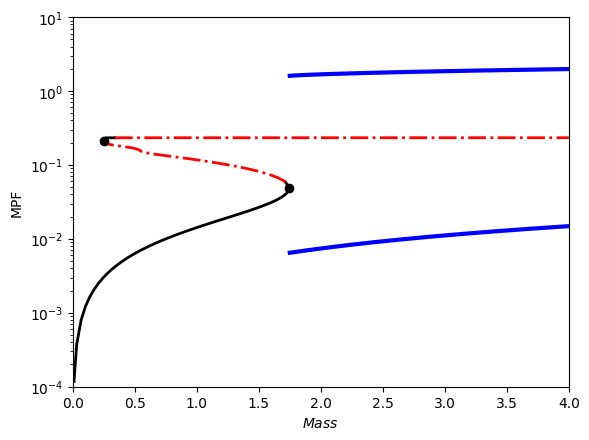

In [15]:
PlotBifurcation(f1_bif1_stst, (:mass, :MPF))
PlotBifurcation(f1_bif1_lcycle, (:mass, :MPF))
xlim([0, 4])
xlabel(L"Mass")
ylabel("MPF")
yscale("log")
ylim([0.0001, 10])
show()

### 1.2 Bifurcation diagram for mass when $V_{c2}=3.8$

Find the steady state during **interphase**

In [16]:
f1_p3 = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=3.8, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2, mass=0.5);

In [17]:
u0 = [0.006,      # MPF
      0.493,      # MPF_P
      0.998,      # Wee1
      0.000,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 40.0)
dtmax = 0.1
alg = Rosenbrock23()
prob = ODEProblem(f1, u0, tspan, f1_p3)
sol = solve(prob, alg; (:dtmax, dtmax))
f1_sol2 = sol
sol.errors

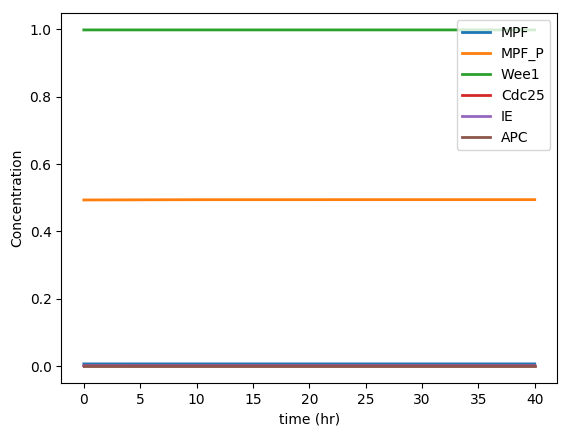

In [18]:
plot(sol.t, sol.u, lw=2)
xlabel("time (hr)")
ylabel("Concentration")
legend(labels = ["MPF","MPF_P","Wee1","Cdc25","IE","APC"])
show()

Find the limit cycle during the **M-phase**

In [19]:
f1_p4 = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=3.8, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2, mass=3.0);

In [20]:
u0 = [0.016,      # MPF
      0.602,      # MPF_P
      0.994,      # Wee1
      0.001,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 25.0)
dtmax = 0.001
sol = find_limit_cycle(f1, u0, tspan, f1_p4; (:dtmax, dtmax))
f1_cycle2 = sol
sol.errors

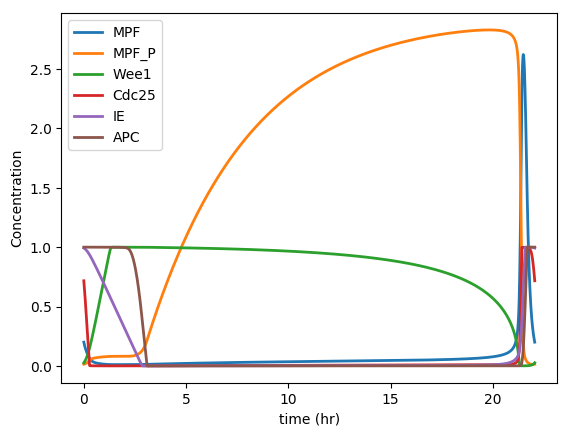

In [21]:
plot(sol.t, sol.u, lw=2)
xlabel("time (hr)")
ylabel("Concentration")
legend(labels = ["MPF","MPF_P","Wee1","Cdc25","IE","APC"])
show()

Follow the steady state from the stable node at the **interphase**

In [22]:
tspan = [0, 40]
dsargs = build_ode(f1, f1_sol2[end], tspan, f1_p3)
dsargs[:pdomain] = Dict("mass"=>[0.01, 4], "V_c2"=>[0.0, 6])
ode = ds[:Generator][:Vode_ODEsystem](dsargs)
ode[:set](pars = Dict("mass"=>0.5))
PC = ds[:ContClass](ode);

In [23]:
name1 = "EQ1"
PCargs = ds[:args](name=name1)
PCargs[:type] = "EP-C"
PCargs[:freepars] = ["mass"]
PCargs[:MaxNumPoints] = 300
PCargs[:MaxStepSize] = 5e-2
PCargs[:MinStepSize] = 1e-5
PCargs[:MaxTestIters] = 20
PCargs[:LocBifPoints] = "all"
PCargs[:SaveEigen] = true
PCargs[:StopAtPoints] = ["B"]
PCargs[:verbosity] = 2
PC[:newCurve](PCargs)

In [24]:
# Commented to save computation, load "CCCMV001_data.jld"
PC[:curves][name1][:backward]()
PC[:curves][name1][:forward]()
PC[:curves][name1][:info]()
f1_PC2 = PC
f1_bif2_stst = bifurcation_curve_ccc(f1_PC2, "EQ1");

B Point found 
0 : 
MPF  =  0.00011770318451
Cdc25  =  1.35682696417e-05
mass  =  0.00999998746228
MPF_P  =  0.00988228097347
APC  =  1.04072645177e-08
Wee1  =  0.999967791343
IE  =  2.604390841e-06

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 : 
MPF  =  0.0471824828245
Cdc25  =  0.00667567111199
mass  =  2.7200884265
MPF_P  =  2.67175196534
APC  =  1.33676537178e-05
Wee1  =  0.822813726088
IE  =  0.00330112706408

Eigenvalues = 

     (-1655.446981,0.000000)
     (-140.998310,0.000000)
     (0.000000,0.000000)
     (-0.199900,0.000000)
     (-21.621903,0.000000)
     (-38.243320,0.000000)


a = 1.8726753754377241

Neutral saddle found!

Neutral saddle found!

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 :

Folow limit cycle at **M-phase**

In [25]:
dtmax = 0.001
f1_bif2_lcycle = follow_limit_cycle(f1_cycle2, 32, [2.721, 4.0], 0.005; (:dtmax, dtmax))

BifurcationCurve{DataStructures.OrderedDict{Symbol,Any},Dict{String,Any}}(DataStructures.OrderedDict{Symbol,Any}(:MPF=>Dict(:max=>[2.4517, 2.45584, 2.45995, 2.464, 2.468, 2.47193, 2.47582, 2.47964, 2.48341, 2.48711  …  2.93856, 2.93981, 2.94104, 2.94229, 2.94353, 2.94476, 2.94599, 2.94721, 2.94845, 2.94967],:length=>[81.3081, 64.2917, 56.4123, 51.5171, 48.051, 45.4066, 43.2893, 41.5357, 40.0467, 38.7577  …  12.5274, 12.5073, 12.4872, 12.4672, 12.4474, 12.4277, 12.4081, 12.3885, 12.3691, 12.3499],:min=>[0.0100999, 0.0101184, 0.010137, 0.0101556, 0.0101741, 0.0101927, 0.0102112, 0.0102298, 0.0102484, 0.0102669  …  0.0146692, 0.0146878, 0.0147064, 0.014725, 0.0147436, 0.0147622, 0.0147808, 0.0147994, 0.0148179, 0.0148365]),:mass=>[2.725, 2.73, 2.735, 2.74, 2.745, 2.75, 2.755, 2.76, 2.765, 2.77  …  3.955, 3.96, 3.965, 3.97, 3.975, 3.98, 3.985, 3.99, 3.995, 4.0]), String["LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC"  …  "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC"

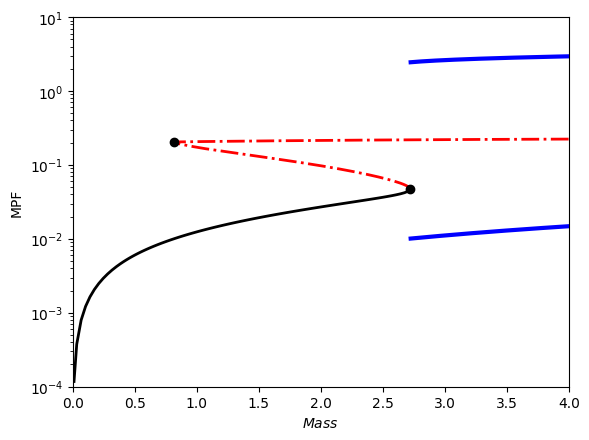

(0.0001, 10.0)

In [26]:
PlotBifurcation(f1_bif2_stst, (:mass, :MPF))
PlotBifurcation(f1_bif2_lcycle, (:mass, :MPF))
xlim([0, 4])
xlabel(L"Mass")
ylabel("MPF")
yscale("log")
ylim([0.0001, 10])

### 1.2 Two-parameter bifurcation diagram for mass and $V_{c2}$

Follow SNIC$_{Mass}$ bifurcation point (first fold)

In [27]:
PC = f1_PC1
namefold1="FO1"
PCargs = ds[:args](name=namefold1)
PCargs[:type] = "LP-C"
PCargs[:initpoint] = "EQ1:LP1"
PCargs[:freepars] = ["mass", "V_c2"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 100
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-4
PCargs[:SaveEigen] = true
PCargs[:SaveJacobian] = true
PCargs[:LocBifPoints] = ["B"]
PCargs[:StopAtPoints] = ["B"]
PCargs[:verbosity] = 2
PCargs[:force] = true
PC[:newCurve](PCargs);

In [28]:
PC[:curves][namefold1][:forward]()
PC[:curves][namefold1][:backward]()
PC[:curves][namefold1][:info]()
f1_PC1 = PC
f1_bif3_fold1 = bifurcation_curve_ccc(PC, "FO1");

B Point found 
0 : 
MPF  =  0.0445035502067
Cdc25  =  0.00340946171386
mass  =  2.78116846476
MPF_P  =  2.73547046941
APC  =  1.35326155668e-05
Wee1  =  0.813528608211
IE  =  0.00334132028844
V_c2  =  5.99999999543

B Point found 
0 : 
MPF  =  0.000276168091749
Cdc25  =  0.0415680779125
mass  =  0.0100000021685
MPF_P  =  0.00972382995671
APC  =  1.2976401328e-08
Wee1  =  0.999959834325
IE  =  3.24730229408e-06
V_c2  =  0.00795594858521

PyCont curve FO1 (type LP-C)
Using model: CCMMV001

Model Info
---------- 

  Variables : APC, Cdc25, IE, MPF, MPF_P, Wee1
  Parameters: APC_T, k_a1, V_i2, k_m1, k_m0, k_m3, k_m2, V_a2, k_c1, Cdc25_T, k_m3a, J_w1, J_w2, k_i1, k_w2, J_i1, J_i2, theta_M, J_a2, J_a1, V_w1, J_c2, k_m1a, alpha, V_c2, IE_T, k_m2a, k_c2a, Chk2_T, mass, Wee1_T, J_c1

Continuation Parameters
----------------------- 

name  =  FO1
force  =  True
auxpars  =  []
freepars  =  ['mass', 'V_c2']
MaxNumPoints  =  100
MaxCorrIters  =  5
MaxTestIters  =  10
MaxStepSize  =  1.0
MinStepSize

Follow Saddle-Node (second fold)

In [29]:
namefold2 = "FO2"
PCargs = ds[:args](name=namefold2)
PCargs[:type] = "LP-C"
PCargs[:initpoint] = "EQ1:LP2"
PCargs[:freepars] = ["mass", "V_c2"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 100
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-7
PCargs[:SaveEigen] = true
PCargs[:verbosity] = 2
PCargs[:LocBifPoints] = ["B"]
PCargs[:StopAtPoints] = ["B"]
PCargs[:force] = true
PC[:newCurve](PCargs)

In [30]:
PC[:curves][namefold2][:forward]()
PC[:curves][namefold2][:backward]()
PC[:curves][namefold2][:info]()
f1_PC1 = PC
f1_bif3_fold2 = bifurcation_curve_ccc(PC, namefold2);

B Point found 
0 : 
MPF  =  0.212201785909
Cdc25  =  0.999999999991
mass  =  0.251641999497
MPF_P  =  0.0391074334819
APC  =  4.17066401329e-05
Wee1  =  0.0679299440737
IE  =  0.0100192191602
V_c2  =  1.74304572007e-09

PyCont curve FO2 (type LP-C)
Using model: CCMMV001

Model Info
---------- 

  Variables : APC, Cdc25, IE, MPF, MPF_P, Wee1
  Parameters: APC_T, k_a1, V_i2, k_m1, k_m0, k_m3, k_m2, V_a2, k_c1, Cdc25_T, k_m3a, J_w1, J_w2, k_i1, k_w2, J_i1, J_i2, theta_M, J_a2, J_a1, V_w1, J_c2, k_m1a, alpha, V_c2, IE_T, k_m2a, k_c2a, Chk2_T, mass, Wee1_T, J_c1

Continuation Parameters
----------------------- 

name  =  FO2
force  =  True
auxpars  =  []
freepars  =  ['mass', 'V_c2']
MaxNumPoints  =  100
MaxCorrIters  =  5
MaxTestIters  =  10
MaxStepSize  =  1.0
MinStepSize  =  1e-07
StepSize  =  0.333717851836
VarTol  =  1e-06
FuncTol  =  1e-06
TestTol  =  0.0001
LocBifPoints  =  ['B']
verbosity  =  2
ClosedCurve  =  50
SaveJacobian  =  False
SaveEigen  =  True
Corrector  =  <bound method 

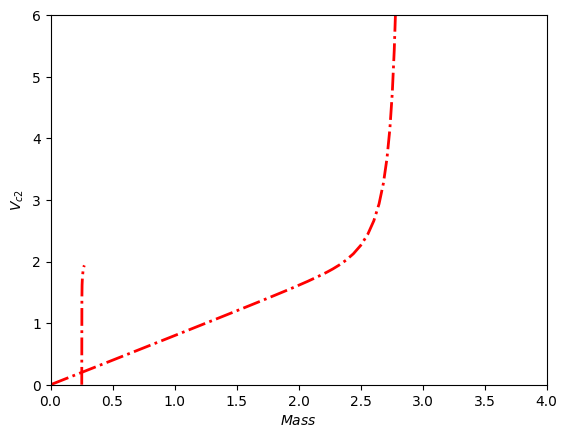

PyObject <matplotlib.text.Text object at 0x7fb9c23be4d0>

In [31]:
PlotBifurcation(f1_bif3_fold1, (:mass, :V_c2))
PlotBifurcation(f1_bif3_fold2, (:mass, :V_c2))
xlim([0, 4])
xlabel(L"Mass")
ylim([0, 6])
ylabel(L"V_{c2}")

## 2 Module for the cell cycle with variable mass

The model for the cell cycle with constant mass is given by

\begin{align}
\frac{d MPF}{dt}       &= k_{m0}Mass - (k_{m2} + k_{m2a}Wee1)\cdot MPF + (k_{m1} + k_{m1a}Cdc25)\cdot MPF_{P} - (k_{m3} + k_{m3a} APC)MPF, \\ 
\frac{d MPF_{P}}{dt}   & = (k_{m2} + k_{m2b}Wee1)MPF - (k_{m1} + k_{m1a}Cdc25)MPF_{P} - (k_{m3}+ k_{m3a} APC)MPF_{P},  \\
\frac{d Wee1}{dt}      &= V_{w1} \frac{Wee1_{T} - Wee1 }{J_{w1} + (Wee1_{T} - Wee1) }  - k_{w2} (MPF + \alpha MPF_{P}) \frac{Wee1}{J_{w2} + Wee1}, \\
\frac{d Cdc25}{dt} &= k_{c1} (MPF + \alpha MPF_{P}) \frac{Cdc25_{T} - Cdc25}{J_{c1} + (Cdc25_{T} - Cdc25)}  - V_{c2}\frac{Cdc25}{J_{c2} + Cdc25}, \\
\frac{d IE}{dt}    &= k_{i1} (MPF + \alpha MPF_{P})\frac{IE_{T} - IE}{J_{i1} + (IE_{T} - IE)} - V_{i2} \frac{IE}{J_{i2} + IE}, \\       
\frac{d APC}{dt}   &= k_{a1}IE_{A} \frac{APC_{T} - APC}{J_{a1}+(APC_{T} - APC)} - V_{a2}\frac{APC}{J_{a2}+APC} , \\
\frac{d Mass}{dt}      &= \mu Mass \left(1-\frac{Mass}{K_{Mass}}\right).
\end{align}

In [32]:
f2 = @ode_def_bare CCMMV001 begin
    dMPF   = k_m0*Mass - (k_m2 + k_m2a*Wee1)*MPF + (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF
    dMPF_P = (k_m2 + k_m2a*Wee1)*MPF - (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF_P
    dWee1  = V_w1*(Wee1_T - Wee1)/(J_w1 + Wee1_T - Wee1) - k_w2*(MPF + MPF_P*alpha)*Wee1/(J_w2 + Wee1)
    dCdc25 = k_c1*(MPF + MPF_P*alpha)*(Cdc25_T - Cdc25)/(J_c1 + Cdc25_T - Cdc25) - V_c2*Cdc25/(J_c2 + Cdc25)
    dIE    = k_i1*(MPF + MPF_P*alpha)*(IE_T - IE)/(J_i1 + IE_T - IE) - V_i2*IE/(J_i2 + IE)
    dAPC   = k_a1*IE*(APC_T - APC)/(J_a1 + APC_T - APC) - V_a2*APC/(J_a2 + APC)
    dMass  = mu*Mass*(1 - Mass/K_Mass)
    end k_m0 k_m1 k_m1a k_m2 k_m2a k_m3 k_m3a V_w1 k_w2 J_w1 J_w2 k_c1 V_c2 J_c1 J_c2 k_i1 V_i2 J_i1 J_i2 k_a1 V_a2 J_a1 J_a2 mu K_Mass alpha Wee1_T Cdc25_T IE_T APC_T Chk2_T theta_M;

In [33]:
function division(u,t,integrator)
    ## Parameters
    ## Set of condition: MPF crosses threshold from positive to negative
    u[1] - f2_p1.theta_M
end # ModelCond

function division_event!(integrator)
    # Divide mass in two
    integrator.u[7] = integrator.u[7]/2
end # ModelEvent!

cb = ContinuousCallback(division, nothing, division_event!, save_positions=(true,false));

### 2.1 Bifurcattion diagram for $V_{c2}$

Find cell cycle oscillations

In [34]:
f2_p1 = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    mu=0.07, K_Mass=2.7, alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2);

In [35]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938]      # Mass
tspan = (0.0, 28.0)
dtmax = 0.001
sol = find_cell_cycle(f2, u0, tspan, f2_p1; (:dtmax, dtmax))
f2_cycle = sol
sol.errors

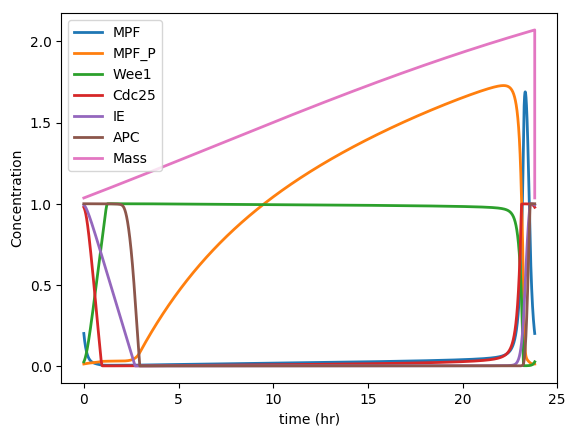

In [36]:
plot(sol.t, sol.u, lw=2)
xlabel("time (hr)")
ylabel("Concentration")
legend(labels = ["MPF","MPF_P","Wee1","Cdc25","IE","APC","Mass"])
show()

Find the steady state during G2 checkpoint $V_{c2}=4.0$

In [37]:
f2_p2 = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=4.0, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    mu=0.07, K_Mass=2.7, alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2);

In [38]:
u0 = [0.042,      # MPF
      2.656,      # MPF_P
      0.886,      # Wee1
      0.005,      # Cdc25_P
      0.002,      # IE_A
      0.000,      # APC_A
      2.699]      # Mass
tspan=(0.0, 40.0)
prob = ODEProblem(f2, u0, tspan, f2_p2)
dtmax = 0.1
sol = solve(prob, alg, callback=cb; (:dtmax, dtmax))
f2_stst = sol
sol.errors

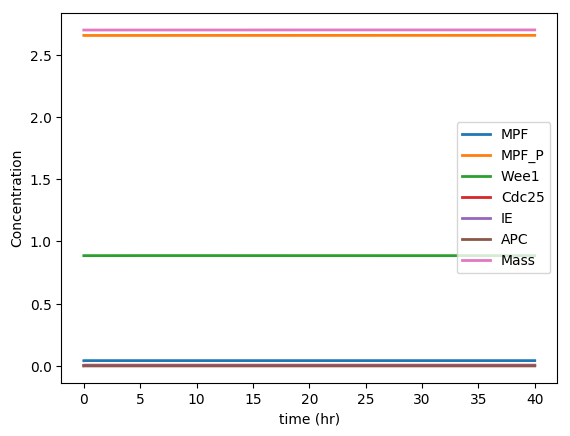

In [39]:
plot(sol.t, sol.u, lw=2)
xlabel("time (hr)")
ylabel("Concentration")
legend(labels = ["MPF","MPF_P","Wee1","Cdc25","IE","APC","Mass"])
show()

Follow cell cycle oscillations (manually)

In [40]:
include("custom_functions.jl")

follow_cell_cycle (generic function with 1 method)

In [41]:
dtmax = 0.001
f2_bif1_lcycle = follow_cell_cycle(f2_cycle, 13, [0.001, 3.469], 0.01; (:dtmax, dtmax));

Follow steady statediring G2 checkpoint

In [42]:
tspan = [0, 40]
dsargs = build_ode(f2, f2_stst[end], tspan, f2_p2)
dsargs[:pdomain] = Dict("V_c2"=>[0, 6])
ode = ds[:Generator][:Vode_ODEsystem](dsargs)
ode[:set](pars = Dict("V_c2"=>4.0))
PC = ds[:ContClass](ode);

In [43]:
name1 = "EQ1"
PCargs = ds[:args](name = name1)
PCargs[:type] = "EP-C"
PCargs[:freepars] = ["V_c2"]
PCargs[:MaxNumPoints] = 300
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-5
PCargs[:StepSize] = 1e-2
PCargs[:LocBifPoints] = "all"
PCargs[:SaveEigen] = true
PCargs[:verbosity] = 2
PCargs[:StopAtPoints] = ["B"]
PC[:newCurve](PCargs)

In [44]:
PC[:curves][name1][:backward]()
PC[:curves][name1][:forward]()
f2_bif1_stst = bifurcation_curve_ccc(PC, "EQ1");

B Point found 
0 : 
MPF  =  0.0384024845866
Cdc25  =  0.00316578678604
Mass  =  2.7
MPF_P  =  2.66067167458
APC  =  1.08038310317e-05
Wee1  =  0.91123631605
IE  =  0.00267476107814
V_c2  =  5.99999999343


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 : 
MPF  =  0.0480443726418
Cdc25  =  0.00778503044712
Mass  =  2.7
MPF_P  =  2.65081525962
APC  =  1.33082483461e-05
Wee1  =  0.825998493129
IE  =  0.00328664964321
V_c2  =  3.47168339841

Eigenvalues = 

     (-1655.641088,0.000000)
     (-115.576535,0.000000)
     (0.000000,0.000000)
     (-0.199879,0.000000)
     (-36.960787,0.000000)
     (-21.768175,0.000000)
     (-0.070000,0.000000)


a = 1.972026717370436

Maximum test function iterations reached.

Neutral saddle found!

B Point found 
0 : 
MPF  =  0.0540606487635
Cdc25  =  0.00353713523247
Mass  =  2.7
MPF_P  =  2.64462404357
APC  =  1.53508163159e-05
Wee1  =  0.648344352564
IE  =  0.00378346260253
V_c2  =  5.999

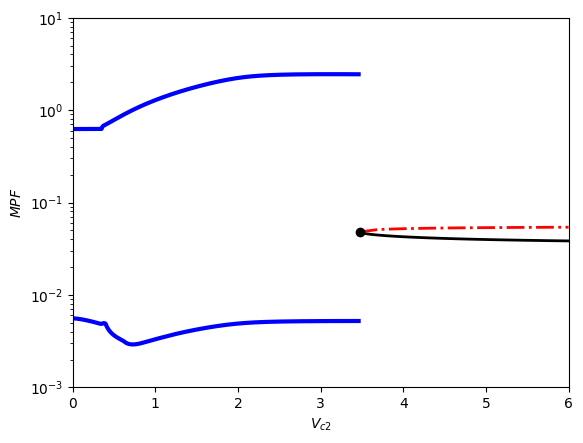

In [45]:
PlotBifurcation(f2_bif1_lcycle, (:V_c2, :MPF))
PlotBifurcation(f2_bif1_stst, (:V_c2, :MPF))
xlim([0, 6])
xlabel(L"V_{c2}")
ylabel(L"MPF")
yscale("log")
ylim([0.001, 10])
show()

In [46]:
@save "simulations_data.jld" f1_bif1_stst f1_bif1_lcycle f1_bif2_stst f1_bif2_lcycle f1_bif3_fold1 f1_bif3_fold2 f2_bif1_stst f2_bif1_lcycle

In [8]:
@load "simulations_data.jld"

8-element Array{Symbol,1}:
 :f1_bif1_lcycle
 :f1_bif1_stst  
 :f1_bif2_lcycle
 :f1_bif2_stst  
 :f1_bif3_fold1 
 :f1_bif3_fold2 
 :f2_bif1_lcycle
 :f2_bif1_stst  

## 3 Modules for the cell cycle and radiation combined

A model for the cell cycle and radiation that captures G2/M transition, cell division and radiation pathway is given by

\begin{align}
\frac{d MPF}{dt}       &= k_{m0}Mass - (k_{m2} + k_{m2a}Wee1)\cdot MPF + (k_{m1} + k_{m1a}Cdc25)\cdot MPF_{P} - (k_{m3} + k_{m3a} APC)MPF, \\ 
\frac{d MPF_{P}}{dt}   & = (k_{m2} + k_{m2b}Wee1)\cdot MPF - (k_{m1} + k_{m1a}Cdc25)\cdot MPF_{P} - (k_{m3}+ k_{m3a} APC)MPF_{P},  \\
\frac{d Wee1}{dt}      &= V_{w1} \frac{Wee1_{T} - Wee1 }{J_{w1} + (Wee1_{T} - Wee1) }  - k_{w2} (MPF + \alpha MPF_{P}) \frac{Wee1}{J_{w2} + Wee1}, \\
\frac{d Cdc25}{dt} &= k_{c1} (MPF + \alpha MPF_{P}) \frac{Cdc25_{T} - Cdc25}{J_{c1} + (Cdc25_{T} - Cdc25)}  - (V_{c2}+k_{c2a}Chk2)\frac{Cdc25}{J_{c2} + Cdc25}, \\
\frac{d IE}{dt}    &= k_{i1} (MPF + \alpha MPF_{P})\frac{IE_{T} - IE}{J_{i1} + (IE_{T} - IE)} - V_{i2} \frac{IE}{J_{i2} + IE}, \\       
\frac{d APC}{dt}   &= k_{a1}IE \frac{APC_{T} - APC}{J_{a1}+(APC_{T} - APC)} - V_{a2}\frac{APC}{J_{a2}+APC}, \\
\frac{d Mass}{dt}      &= \mu Mass \left( 1 - \frac{Mass}{K_{Mass}} \right),\\
\frac{d Chk2}{dt}  &= k_{h1} ATM \, DSB \frac{Chk2_{T} - Chk2 }{J_{h1} + (Chk2_{T} - Chk2) }  - V_{h2} \frac{Chk2}{J_{h2} + Chk2},\\  
\frac{d ATM}{dt}       &= k_{t1}DSB\frac{ATM_{T}-ATM}{J_{t1}+ATM_{T}-ATM}- V_{t2}\frac{ATM}{J_{t2}+ATM},\\
\frac{d DSB}{dt}       &= k_{d1} \dot D(t) - k_{d2}ATM\,DSB.
\end{align}

The first seven equation correspond to the Cell Cycle module, and the last three equations correspond to the Radiation pathway module. The parameters has been chosen to adapt the cell cycle behaviour.

The question of interest is how radiation affects the cell cell cycle dynamics, in particular, the G2/M trasition. If we want to investigate the effect of radiation on other components of the cell cycle, the module for the cell cycle must be modified to account for the these components.

In [190]:
HeaviSide(t, a, b) = (a < t < b) ? 1. : 0.
f3 = @ode_def_bare CCRMV003 begin
    ## System of ODE (vector field)
    dMPF   = k_m0*Mass - (k_m2 + k_m2a*Wee1)*MPF + (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF
    dMPF_P = (k_m2 + k_m2a*Wee1)*MPF - (k_m1 + k_m1a*Cdc25)*MPF_P - (k_m3 + k_m3a*APC)*MPF_P
    dWee1  = V_w1*(Wee1_T - Wee1)/(J_w1 + Wee1_T - Wee1) - k_w2*(MPF + MPF_P*α)*Wee1/(J_w2 + Wee1)
    dCdc25 = k_c1*(MPF + MPF_P*α)*(Cdc25_T - Cdc25)/(J_c1 + Cdc25_T - Cdc25) - (V_c2+k_c2a*Chk2)*Cdc25/(J_c2 + Cdc25)
    dIE    = k_i1*(MPF + MPF_P*α)*(IE_T - IE)/(J_i1 + IE_T - IE) - V_i2*IE/(J_i2 + IE)
    dAPC   = k_a1*IE*(APC_T - APC)/(J_a1 + APC_T - APC) - V_a2*APC/(J_a2 + APC)
    dMass  = μ*Mass*(1 - Mass/K_Mass)
    dChk2  = k_h1*ATM*DSB*(Chk2_T - Chk2)/(J_h1 + Chk2_T - Chk2) - V_h2*Chk2/(J_h2 + Chk2)
    dATM   = k_t1*DSB*(ATM_T - ATM)/(J_t1 + ATM_T - ATM) - V_t2*ATM/(J_t2 + ATM)
    dDSB   = -k_d2*ATM*DSB + k_d1*RadScheme(t)
end k_m0 k_m1 k_m1a k_m2 k_m2a k_m3 k_m3a V_w1 k_w2 J_w1 J_w2 k_c1 V_c2 k_c2a J_c1 J_c2 k_i1 V_i2 J_i1 J_i2 k_a1 V_a2 J_a1 J_a2 k_h1 V_h2 J_h1 J_h2 k_t1 V_t2 J_t1 J_t2 k_d1 k_d2 α μ K_Mass Wee1_T Cdc25_T IE_T APC_T Chk2_T ATM_T θ_M;

**Cell division events**

When the concentration of MPF crosses the threshold for mitosis $\theta_M$ from positive to negative, the mass on the cell splits in two.

In [191]:
function division(u,t,integrator)
    # MPF crosses threshold
    θ_M = 0.2
    u[1] - θ_M
end # division

function division_event!(integrator)
    # Divide mass in two
    integrator.u[7] = integrator.u[7]/2
end # division_event!

# Event happens from positive to negative
f3_cb = ContinuousCallback(division, nothing, division_event!, save_positions=(true,false));

Numerical solution parameters

In [192]:
dtmax = 0.001
alg = Rosenbrock23();

### 3.1 Simulations at different radiation pulse intensity and timing

Parameter values

In [193]:
f3_p = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.4, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    k_h1=0.32, V_h2=1.9, J_h1=0.01, J_h2=0.01, k_t1=30.0, V_t2=3.8, J_t1=0.01, J_t2=0.01, k_d1=35.00, k_d2=0.4, 
    α=0.05, μ=0.07, K_Mass=2.7, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, ATM_T=1.0, θ_M=0.2);

ODE problem

In [194]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 40.0)
f3_prob = ODEProblem(f3, u0, tspan, f3_p);

**Cell cycle**. No radiation, control case.

In [53]:
RadScheme(t) = 0.
f3_solnorad = solve(f3_prob, alg, callback=f3_cb; (:dtmax, dtmax))
f3_solnorad.errors

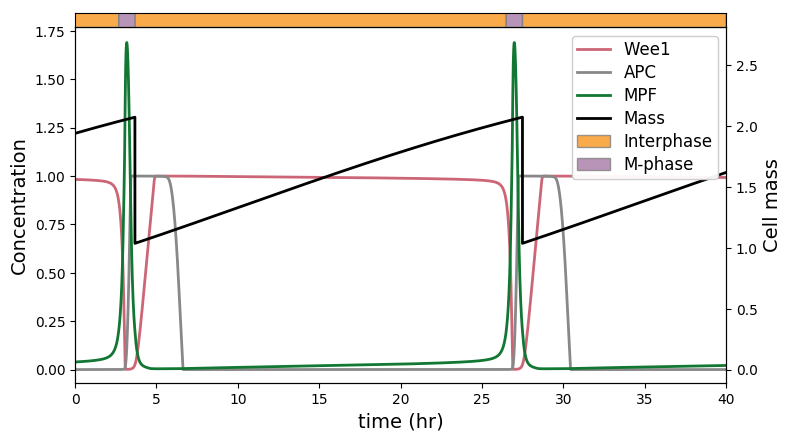

In [54]:
fig = PlotSolution(f3_solnorad)
if saveplots savefig("figures/solnorad.pdf", bbox_inches="tight") end

The plot shows one full cell cycle. During interphase, the concentration of active MPF is low and Wee1 is fully active; but as the concentration of MPF increases as a result of cell growth, the activity of MPF reaches the threshold for mitosis $\theta_M=0.2$, and the cell enters mitosis. During M-phase, Wee1 becomes inactive, the concentration of MPF increases and decreases as APC becomes active. Right after the MPF concentration decreases to $\theta_M=0.2$, the cel division event divides the cell mass in two.

**Radiation scheme: pusle of 0.4Gy moments before mitotic entry.**

In [55]:
# Radiation scheme: 
# 0.4*60 Gy/min*min/hr starts at 1.5 hrs for 1/60 hrs
rad_rate = .4
t_0 = 2.3; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
f3_solrad1 = solve(f3_prob, alg, callback=f3_cb; (:dtmax, dtmax))
f3_solrad1.errors

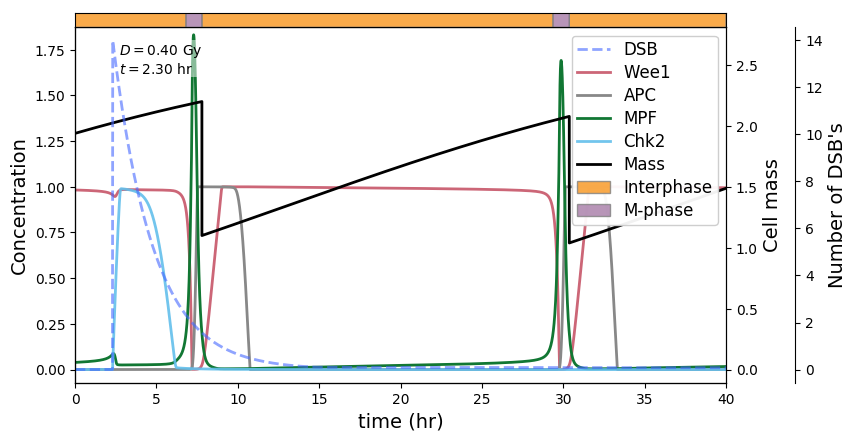

In [56]:
fig = PlotSolution(f3_solrad1, [t_0, t_d, rad_rate])
if saveplots savefig("figures/solrad1.pdf", bbox_inches="tight") end

Mitotic entry is delayed (around 15 h) after induced radiation. Radiation dose is low but sufficiently high to delay mitosis.

**Radiation scheme: pulse of 0.2 Gy moments before mitosis.** Same time but lower intensity for the radiation pulse.

In [57]:
# Radiation scheme: 
# 0.2*60 Gy/min*min/hr starts at 1.5 hrs for 1/60 hrs
rad_rate = 0.2
t_0 = 2.3; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
f3_solrad2 = solve(f3_prob, alg, callback=f3_cb; (:dtmax, dtmax))
f3_solrad2.errors

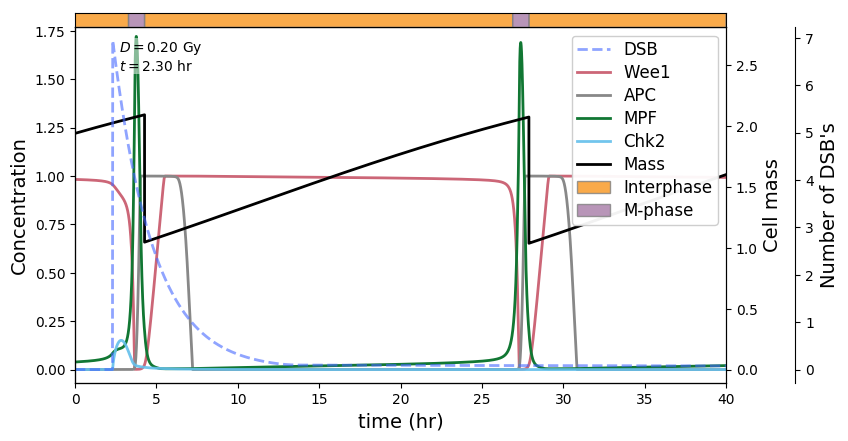

In [58]:
fig = PlotSolution(f3_solrad2, [t_0, t_d, rad_rate])
if saveplots savefig("figures/solrad2.pdf", bbox_inches="tight") end 

Mitotic entry is unaffected after induced radiation. Radiation dose is too low to induce a quick response.

**Radiation scheme: pulse of 0.2Gy few more moments before radiation.** Same radiation intensity but 12 min (0.2 hr) before comprared to previous case.

In [59]:
# Radiation scheme: 
# 0.2*60 Gy/min*min/hr starts at 1.2 hrs for 1/60 hrs
rad_rate = 0.2
t_0 = 2.1; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
f3_solrad3 = solve(f3_prob, alg, callback=f3_cb; (:dtmax, dtmax))
f3_solrad3.errors

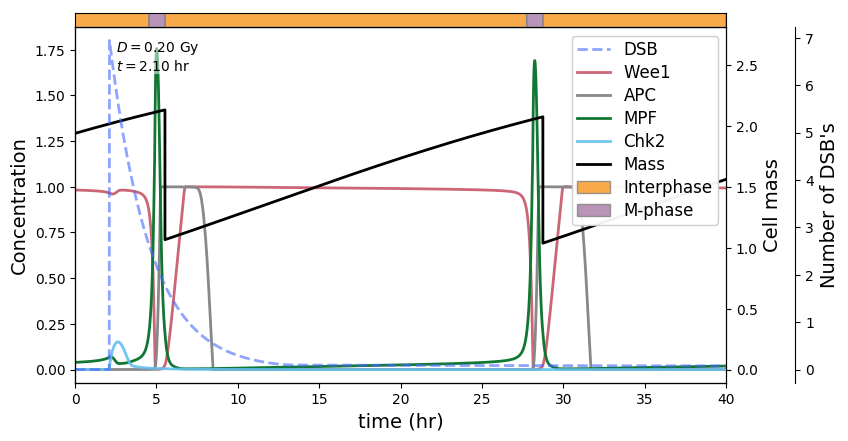

In [60]:
fig = PlotSolution(f3_solrad3, [t_0, t_d, rad_rate])
if saveplots savefig("figures/solrad3.pdf", bbox_inches="tight") end

Mitotic entry is delayed eventhough the intensity is very low, but it happened enough time before mitosis so the response could be activated.

In [61]:
f1_bif1_lcycle.d[:MPF]

Dict{Symbol,Array{Float64,1}} with 3 entries:
  :max    => [1.60713, 1.61248, 1.61697, 1.62104, 1.62482, 1.6284, 1.63183, 1.6…
  :length => [41.9693, 32.7421, 29.1876, 26.989, 25.4063, 24.1749, 23.1705, 22.…
  :min    => [0.0064886, 0.00652575, 0.0065629, 0.00660005, 0.0066372, 0.006674…

### 3.2 Superimposing solutions on bifurcation diagram for the total inactivation rate of Cdc25 ($V_{c2}+k_{c2a}Chk2_P$)

In [62]:
f2_bif1_lcycle.d[:MPF][:length]

346-element Array{Float64,1}:
  13.0636
  13.0637
  13.0638
  13.0639
  13.064 
  13.0641
  13.0642
  13.0644
  13.0645
  13.0646
  13.0647
  13.0648
  13.0649
   ⋮     
 125.487 
 128.28  
 131.388 
 134.887 
 138.886 
 143.538 
 149.081 
 155.898 
 164.664 
 176.731 
 195.385 
 232.203 

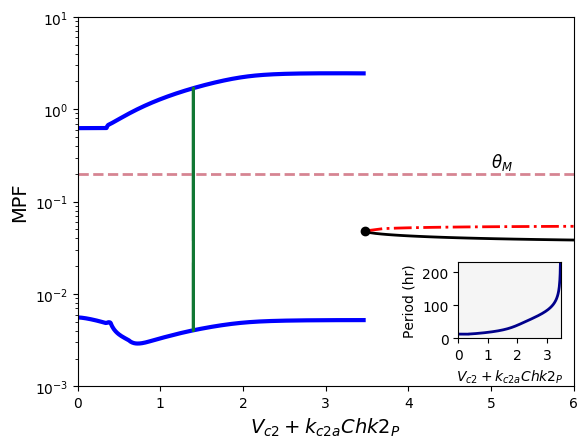

In [73]:
plot([0.0, 6.0], [0.2, 0.2], "--", color=red1, lw=2, alpha=0.8)
text(5.0, 0.21, L"θ_M", va="bottom", fontsize=12)
PlotBifurcation(f2_bif1_stst, (:V_c2, :MPF))
PlotBifurcation(f2_bif1_lcycle, (:V_c2, :MPF))
plot(f3_p.V_c2 + f3_p.k_c2a*f3_solnorad[8, :], f3_solnorad[1, :], color=green2, lw=2)
xlim([0, 6])
xlabel(L"V_{c2} + k_{c2a} Chk2_P", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.001, 10])
# Inset for the length of the cell cycle
fig = gcf()
ax = fig[:add_axes]([0.72, 0.21, 0.16, 0.16], facecolor="WhiteSmoke")
ax[:plot](f2_bif1_lcycle.d[:V_c2], f2_bif1_lcycle.d[:MPF][:length], color="DarkBlue", lw=2)
axis([0.0, f2_bif1_stst.special_points["LP"][1][:V_c2], 0.0, maximum(f2_bif1_lcycle.d[:MPF][:length])])
xlabel(L"V_{c2} + k_{c2a} Chk2_P")
ylabel("Period (hr)")
ax[:set_xticks]([0.0, 1.0, 2.0, 3.0])
ax[:set_yticks]([0.0, 100.0, 200.0]);
if saveplots savefig("figures/bif1_norad.pdf", bbox_inches="tight") end

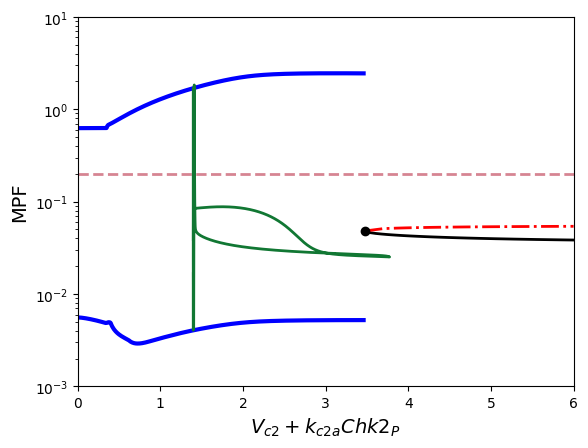

In [64]:
plot([0.0, 6.0], [0.2, 0.2], "--", color=red1, lw=2, alpha=0.8)
PlotBifurcation(f2_bif1_stst, (:V_c2, :MPF))
PlotBifurcation(f2_bif1_lcycle, (:V_c2, :MPF))
plot(f3_p.V_c2 + f3_p.k_c2a*f3_solrad1[8, :], f3_solrad1[1, :], color=green2, lw=2)
xlim([0, 6])
xlabel(L"V_{c2} + k_{c2a} Chk2_P", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.001, 10])
if saveplots savefig("figures/bif1_rad1.pdf", bbox_inches="tight") end

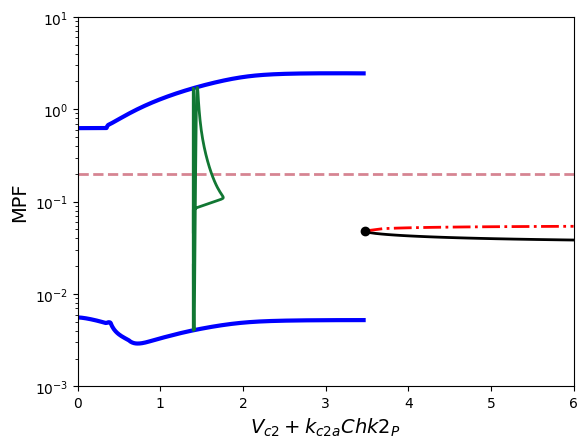

In [65]:
plot([0.0, 6.0], [0.2, 0.2], "--", color=red1, lw=2, alpha=0.8)
PlotBifurcation(f2_bif1_stst, (:V_c2, :MPF))
PlotBifurcation(f2_bif1_lcycle, (:V_c2, :MPF))
tt = linspace(1.2, 40.0, 1000)
plot(f3_p.V_c2 + f3_p.k_c2a*f3_solrad2(tt)[8, :], f3_solrad2(tt)[1, :], color=green2, lw=2)
xlim([0, 6])
xlabel(L"V_{c2} + k_{c2a} Chk2_P", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.001, 10])
if saveplots savefig("figures/bif1_rad2.pdf", bbox_inches="tight") end

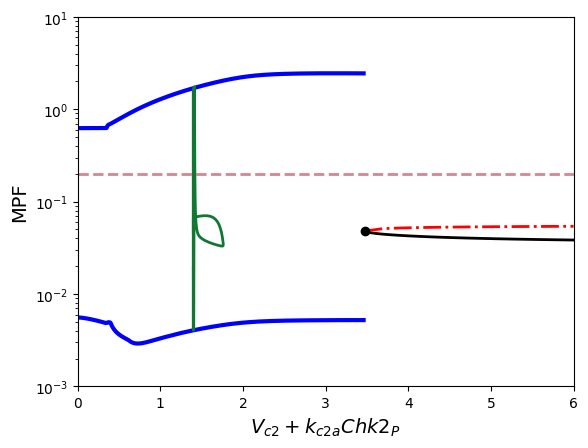

In [66]:
plot([0.0, 6.0], [0.2, 0.2], "--", color=red1, lw=2, alpha=0.8)
PlotBifurcation(f2_bif1_stst, (:V_c2, :MPF))
PlotBifurcation(f2_bif1_lcycle, (:V_c2, :MPF))
tt = linspace(1.2, 40.0, 1000)
plot(f3_p.V_c2 + f3_p.k_c2a*f3_solrad3(tt)[8, :], f3_solrad3(tt)[1, :], color=green2, lw=2)
xlim([0, 6])
xlabel(L"V_{c2} + k_{c2a} Chk2_P", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.001, 10])
if saveplots savefig("figures/bif1_rad3.pdf", bbox_inches="tight") end

### 3.3 Superposition solutions on bifurcation diagrams for cell mass (cell size)

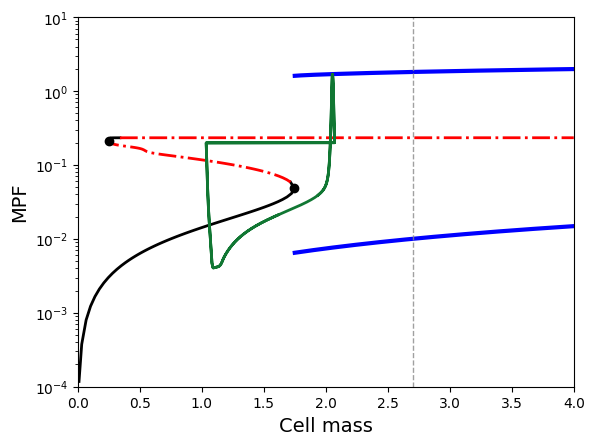

In [67]:
PlotBifurcation(f1_bif1_stst, (:mass, :MPF))
PlotBifurcation(f1_bif1_lcycle, (:mass, :MPF))
plot(f3_solnorad[7, :], f3_solnorad[1, :], color=green2, lw=2)
plot([f3_p.K_Mass, f3_p.K_Mass], [0.0, 10.0], color=gray1, "--", lw=1, alpha=0.8)
xlim([0, 4])
xlabel("Cell mass", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.0001, 10])
if saveplots savefig("figures/bif2_norad.pdf", bbox_inches="tight") end

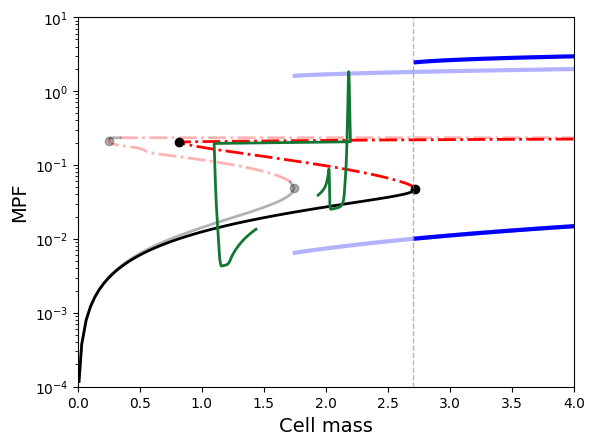

In [68]:
PlotBifurcation(f1_bif1_stst, (:mass, :MPF))
PlotBifurcation(f1_bif1_lcycle, (:mass, :MPF))
lns = gca()[:lines]
for k in 1:length(lns)
    lns[k][:set_alpha](0.3)
end
PlotBifurcation(f1_bif2_stst, (:mass, :MPF))
PlotBifurcation(f1_bif2_lcycle, (:mass, :MPF))
plot([f3_p.K_Mass, f3_p.K_Mass], [0.0, 10.0], color=gray1, "--", lw=1, alpha=0.6)
tt = 0:0.01:15
plot(f3_solrad1(tt)[7, :], f3_solrad1(tt)[1, :], color=green2, lw=2)
xlim([0, 4])
xlabel("Cell mass", fontsize=14)
ylabel("MPF", fontsize=14)
yscale("log")
ylim([0.0001, 10])
if saveplots savefig("figures/bif2_rad1.pdf", bbox_inches="tight") end

### 3.4 Superposition solutions on two-parameter bifurcation diagram for cell mass (cell size) and total inactivation of Cdc25 ($V_{c2}+k_{c2a}Chk2$)

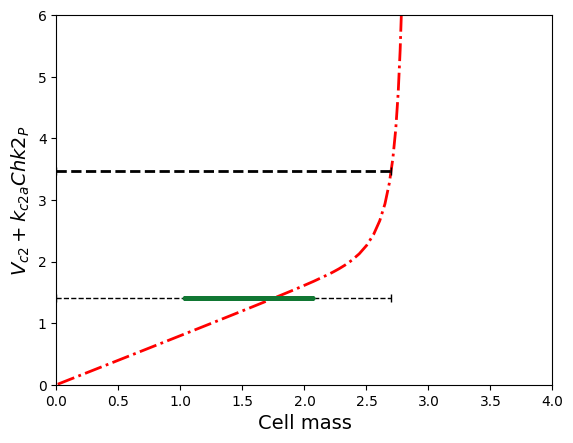

In [69]:
#plot([p0.K_Mass, p0.K_Mass], [0.0, 10.0], color=gray1, "--", lw=1, alpha=0.8)
# Fold bifurcation curve
PlotBifurcation(f1_bif3_fold1, (:mass, :V_c2))
# Base lines
plot([0.0, f3_p.K_Mass], [f3_p.V_c2, f3_p.V_c2], color="k", lw=1, "--|")
SNIC_V_c2 = f2_bif1_stst.special_points["LP"][1][:V_c2]
plot([0.0, f3_p.K_Mass], [SNIC_V_c2, SNIC_V_c2], color="k", lw=2, "--|")
# Superimposed solutions
plot(f3_solnorad[7, :], f3_p.V_c2 + f3_p.k_c2a*f3_solnorad[8, :], color=green2, lw=3)
xlim([0, 4])
xlabel("Cell mass", fontsize=14)
ylim([0, 6])
ylabel(L"V_{c2}+k_{c2a}Chk2_P", fontsize=14)
if saveplots savefig("figures/bif3_norad.pdf", bbox_inches="tight") end

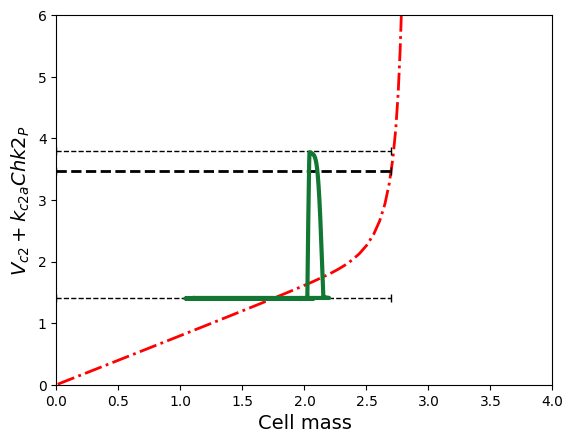

In [70]:
#plot([p0.K_Mass, p0.K_Mass], [0.0, 10.0], color=gray1, "--", lw=1, alpha=0.8)
# Fold bifurcation curve
PlotBifurcation(f1_bif3_fold1, (:mass, :V_c2))
# Base lines
plot([0.0, f3_p.K_Mass], [f3_p.V_c2, f3_p.V_c2], color="k", lw=1, "--|")
SNIC_V_c2 = f2_bif1_stst.special_points["LP"][1][:V_c2]
plot([0.0, f3_p.K_Mass], [SNIC_V_c2, SNIC_V_c2], color="k", lw=2, "--|")
plot([0.0, f3_p.K_Mass], [f3_p.V_c2 + f3_p.k_c2a, f3_p.V_c2 + f3_p.k_c2a], color="k", lw=1, "--|")
# Superimposed solutions
plot(f3_solrad1[7, :], f3_p.V_c2 + f3_p.k_c2a*f3_solrad1[8, :], color=green2, lw=3)
xlim([0, 4])
xlabel("Cell mass", fontsize=14)
ylim([0, 6])
ylabel(L"V_{c2}+k_{c2a}Chk2_P", fontsize=14)
if saveplots savefig("figures/bif3_norad.pdf", bbox_inches="tight") end

### 3.5 No effect of radiation

In [195]:
u0 = [0.039,      # MPF
      1.660,      # MPF_P
      0.982,      # Wee1
      0.027,      # Cdc25_P
      0.001,      # IE_A
      0.000,      # APC_A
      1.938,      # Mass
      0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 30.0)
f3_prob = ODEProblem(f3, u0, tspan, f3_p);

In [196]:
# Radiation scheme: 
# 0.1*60 Gy/min*min/hr starts at 1.0 hrs for 1/60 hrs
rad_rate = 0.1
t_0 = 1.0; t_d = 1/60
RadScheme(t) = rad_rate*60*HeaviSide(t, t_0, t_0 + t_d)
f3_solrad4 = solve(f3_prob, alg, callback=f3_cb; (:dtmax, dtmax))
f3_solrad4.errors

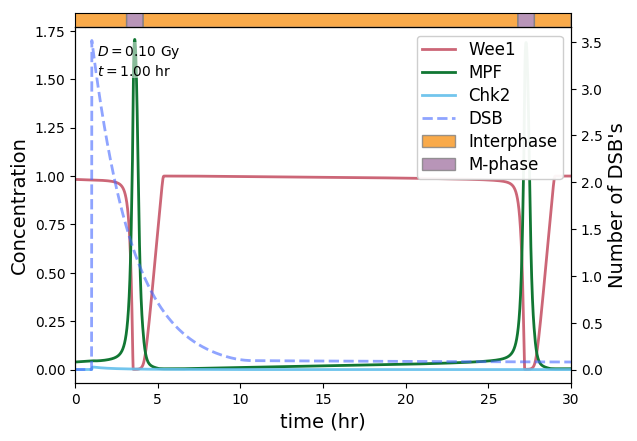

In [198]:
fig = PlotSolution2(f3_solrad4, [t_0, t_d, rad_rate]);
if saveplots savefig("figures/solrad4.pdf", bbox_inches="tight") end

## 4 Module for radiation

A model for the cell cycle and radiation that captures G2/M transition, cell division and radiation pathway is given by

\begin{align}
\frac{d Chk2}{dt}  &= k_{h1} ATM \, DSB \frac{Chk2_{T} - Chk2 }{J_{h1} + (Chk2_{T} - Chk2) }  - V_{h2} \frac{Chk2}{J_{h2} + Chk2},\\  
\frac{d ATM}{dt}       &= k_{t1}DSB\frac{ATM_{T}-ATM}{J_{t1}+ATM_{T}-ATM}- V_{t2}\frac{ATM}{J_{t2}+ATM},\\
\frac{d DSB}{dt}       &= k_{d1} \dot D(t) - k_{d2}ATM\,DSB.
\end{align}

In [199]:
f4 = @ode_def_bare CCRMV003 begin
    ## System of ODE (vector field)
    dChk2  = k_h1*ATM*DSB*(Chk2_T - Chk2)/(J_h1 + Chk2_T - Chk2) - V_h2*Chk2/(J_h2 + Chk2)
    dATM   = k_t1*DSB*(ATM_T - ATM)/(J_t1 + ATM_T - ATM) - V_t2*ATM/(J_t2 + ATM)
    dDSB   = -k_d2*ATM*DSB + k_d1*RadScheme(t)
end k_h1 V_h2 J_h1 J_h2 k_t1 V_t2 J_t1 J_t2 k_d1 k_d2 Chk2_T ATM_T;

In [200]:
f4_p = @NT(k_h1=0.32, V_h2=1.9, J_h1=0.01, J_h2=0.01, k_t1=30.0, V_t2=3.8, J_t1=0.01, J_t2=0.01, 
    k_d1=35.00, k_d2=0.4, Chk2_T=1.0, ATM_T=1.0);

### 4.1 Simulations to match Rothkamm (2003, PNAS) experiments

Radiation of 20, 5, and 1.2 mGy

In [201]:
u0 = [0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 26.0)
f4_prob = ODEProblem(f4, u0, tspan, f4_p);
# Radiation scheme: 
dose = 20/1000 # 20 mGy
rad_rate = 40/1000*60 # 40 mGy per min * 60 min / hr
t_0 = 0.0; t_d = dose / rad_rate # Gy / Gy/hr = hr 
RadScheme(t) = rad_rate*HeaviSide(t, t_0, t_0 + t_d)
f4_solrothkamm1 = solve(f4_prob, alg; (:dtmax, dtmax))
f4_solrothkamm1.errors

In [209]:
rad_rate/60

0.04

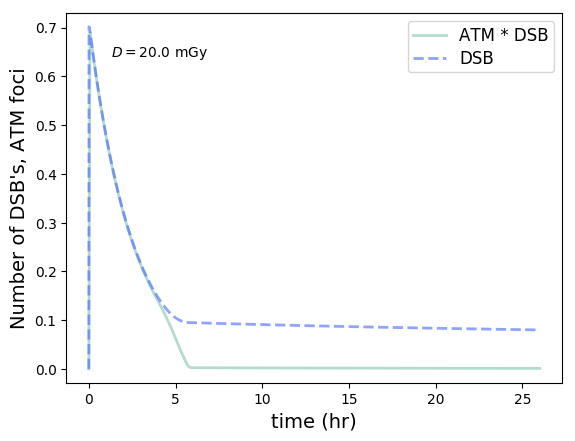

In [203]:
fig = PlotRothkamm(f4_solrothkamm1, [t_0, t_d, rad_rate]);
if saveplots savefig("figures/solrothkamm1.pdf", bbox_inches="tight") end

In [204]:
u0 = [0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 26.0)
f4_prob = ODEProblem(f4, u0, tspan, f4_p);
# Radiation scheme: 
dose = 5/1000 # 5 mGy
rad_rate = 40/1000*60 # 40 mGy per min * 60 min / hr
t_0 = 0.0; t_d = dose / rad_rate # Gy / Gy/hr = hr 
RadScheme(t) = rad_rate*HeaviSide(t, t_0, t_0 + t_d)
f4_solrothkamm2 = solve(f4_prob, alg; (:dtmax, dtmax))
f4_solrothkamm2.errors

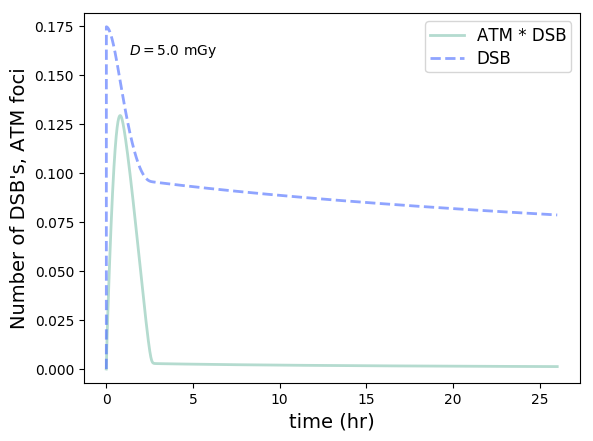

In [205]:
fig = PlotRothkamm(f4_solrothkamm2, [t_0, t_d, rad_rate]);
if saveplots savefig("figures/solrothkamm2.pdf", bbox_inches="tight") end

In [206]:
u0 = [0.000,      # Chk2_P
      0.000,      # ATM
      0.000]      # DSB
tspan = (0.0, 26.0)
f4_prob = ODEProblem(f4, u0, tspan, f4_p);
# Radiation scheme: 
dose = 1.2/1000 # 1.2 mGy
rad_rate = 40/1000*60 # 40 mGy per min * 60 min / hr
t_0 = 0.0; t_d = dose / rad_rate # Gy / Gy/hr = hr 
RadScheme(t) = rad_rate*HeaviSide(t, t_0, t_0 + t_d)
f4_solrothkamm3 = solve(f4_prob, alg; (:dtmax, dtmax))
f4_solrothkamm3.errors

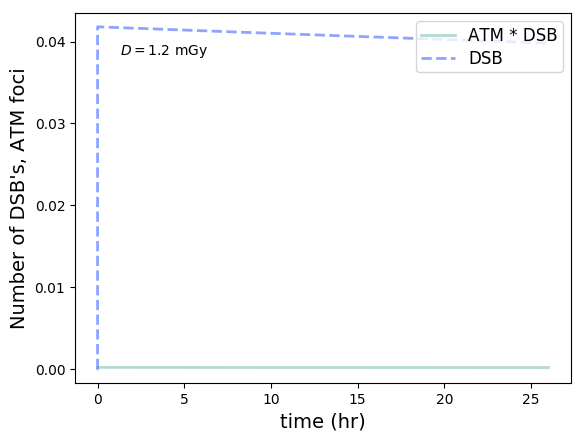

In [207]:
fig = PlotRothkamm(f4_solrothkamm3, [t_0, t_d, rad_rate]);
if saveplots savefig("figures/solrothkamm3.pdf", bbox_inches="tight") end